# Numerical Integration

Here we will study numerical integration in Python as provided by routines in `scipy.integrate`. The main routine is `quad` or `quad_vec`, but there are many other methods implemented that are useful in some circumstances.

## Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integ
import scipy.optimize as opt
import scipy.interpolate as interp
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

## Documentation

As always we should check the documentation. There are routines for Newton-Cotes integration, `newton_cotes`, for integrating functions, in particular `romberg`, `quad`, and `quad_vec`, and for integrating from tabulated values, in particular `cumtrapz`, `simps`, and `romb`. We should check the documentation for all of these and some of them will be used in the prelab, lab, and homework. Here we will only look at a few of them.

In [ ]:
integ?

In [ ]:
integ.newton_cotes?

In [ ]:
print("n=1: [trapezoidal rule] ", integ.newton_cotes(1))
print("n=2: [Simpson's rule] ", integ.newton_cotes(2))
print("n=10: ", integ.newton_cotes(10))

In [ ]:
integ.trapezoid?

In [ ]:
integ.cumulative_trapezoid?

In [ ]:
integ.romberg?

In [ ]:
integ.quad?

The work horse routine is `quad`. It is actually a wrapper for many integration routines and techniques. In fact, it has so many features that historically it required its own function to explain some of its more esoteric features, `quad_explain`! All the documentation is now included in `quad` itself so this extra function is no longer required and it appears to have been removed in some recent version of scipy.

Finally, there is a version of `quad` than can handle vectorized functions, `quad_vec`. This is a function that can compute multiple integrals over the same interval all at once. It is a relatively new function so is not as commonly used. A more common way to handle repeated evaluation of integrals is to use a loop. We will explore both options here.

In [ ]:
integ.quad_vec?

## Using `quad`

Both `quad` and `quad_vec` are based on the same ideas so we will discuss the basics in terms of `quad`. To get started using it let us consider a simple integral,
$$ \int_0^2 \mathrm{e}^x \,\mathrm{d}x = \mathrm{e}^2 - 1. $$
We can perform this integral using `quad` as shown below.

In [2]:
integ.quad(np.exp, 0, 2)

(6.3890560989306495, 7.093277186654589e-14)

Notice that `quad` **returns two quantities.** As described in the documentation these are the value of the integral and an estimate of the error in the integral. Note that this error estimate is based on the convergence of the integration algorithm, it is **not** the true error. If `quad` knew the true value it would return it and the error would be zero!

In principle we should always check the error estimate as this is an indication of the convergence of the algorithm and how much we should trust the result. Since `quad` returns the results in what is a called a `tuple` in Python, we can store the results using
```python
(res, err) = integ.quad(np.exp, 0, 2)
```

Alternatively we can entirely ignore the error. This is not good practice, but is often expedient (that is, once we know the integral converges we can start ignoring the error). Another common idiom is thus to just pull out the result by extracting the first element of the `tuple` (the element with index 0),
```python
res = integ.quad(np.exp, 0, 2)[0]
```

For our simple case we have ...

In [3]:
res_true = np.exp(2) - 1
(res, err) = integ.quad(np.exp, 0, 2)
print(f"True value of integral = {res_true} quad estimate of integral = {res}")
print(f"True error in integral = {np.abs(res_true-res)} quad estimate of error = {err}")

True value of integral = 6.38905609893065 quad estimate of integral = 6.3890560989306495
True error in integral = 8.881784197001252e-16 quad estimate of error = 7.093277186654589e-14


We can get detailed information of what `quad` is doing by using `full_output=True`.

In [4]:
integ.quad(np.exp, 0, 2, full_output=True)

(6.3890560989306495,
 7.093277186654589e-14,
 {'neval': 21,
  'last': 1,
  'iord': array([         1,          0,          0,          0,  540702760,
         1701470831,  539784291, 1864383097, 1667590754, 1998597236,
         1651449914, 1952671082, 1310735648,  744844911, 1953853216,
         1651449914, 1952671082, 1310735648,  694513263,  540945696,
         1886221678, 1684942457, 1634890337,       2681,  536873593,
         1193305711, 1634891119, 1931502709, 1768186216, 1763731310,
         2120223342, 1702379822, 1668296307, 1919904879, 1752393069,
         1998597216, 1751345512,  544434464,  544501614, 1767994977,
         1818386796, 1769414757, 1612736628, 2017537662, 1882092389,
         1869377379,    3039346,      32759,       1328,          0],
        dtype=int32),
  'alist': array([0.00000000e+000, 0.00000000e+000, 6.95151139e-310, 6.95151139e-310,
         6.95151139e-310, 6.95151139e-310, 6.95151139e-310, 6.95151139e-310,
         6.95151139e-310, 6.95151139e-310, 

This returns a lot of extra information in a data structure called a `dictionary` in Python. (This is called an associative array, hash map, or something similar in other languages.) It is best to store this and look at it more closely. The full details are contained in the documentation. We will focus on only one entry, the number of function evaluations required which is contained in `neval`.

In [5]:
(res, err, info) = integ.quad(np.exp, 0, 2, full_output=True)
print(f"Evaluation of the integral required {info['neval']} function evaluations")

Evaluation of the integral required 21 function evaluations


In [6]:
info.keys()

dict_keys(['neval', 'last', 'iord', 'alist', 'blist', 'rlist', 'elist'])

## Incandescent Light Bulb

The great invention of Edison that brought safe, controllable light to the world has now largely been relegated to the dustbin of history due to its energy inefficiency. Here we will study this through a simple model. We treat the light bulb as a black body. This is a simple approximation that describes many of the features of a light bulb, but is not a complete model. The intensity of a black body, the energy emitted per unit time in some solid angle as a function of the wavelength of the emitted light, is
$$ I(\lambda) = \frac{2\pi A h c^2}{\lambda^5 (\mathrm{e}^{h c/\lambda k_B T} - 1)}, $$
where $A$ is the surface area of the black body, $h=6.626\times10^{-34}\;\mathrm{J/s}$ is Planck's constant, $c$ is the speed of light, $k_B=1.381\times10^{-23}\;\mathrm{J/K}$ is Boltzmann's constant, and $T$ is the temperature of the object.

A black body at any temperature emits at all wavelengths. Our eye is only sensitive to "visible light", that is, wavelengths roughly in the range $300\le\lambda(\mathrm{nm})\le 750$. Any radiation emitted at smaller or larger frequencies is thus "wasted energy" as far as we are concerned. For this reason let us define the efficiency, $\eta$, as the ratio of the emitted radiation we can observe to the total emitted radiation
$$ \eta \equiv \frac{\int_{\lambda_1}^{\lambda_2} I(\lambda) \mathrm{d}\lambda}{\int_0^\infty I(\lambda) \mathrm{d}\lambda}. $$

To use these we transform it into a simpler form. Let $x_i(T) \equiv \frac{h c}{\lambda_i k_B T}$ and note that we can perform the integral in the denominator leaving the efficiency as
$$ \eta(T)  = \frac{15}{\pi^4} \int_{x_2(T)}^{x_1(T)} \frac{x^3}{\mathrm{e}^x-1} \mathrm{d}x. $$
We will use $\lambda_1=300\;\mathrm{nm}$ and $\lambda_2=750\;\mathrm{nm}$ in what follows to estimate the efficiency of a light bulb for visible radiation.

### Loops

We wish to find the temperature at which the light bulb runs at maximum efficiency. To do this we need to evaluate the efficiency for a grid of temperatures. Unfortunately `quad` does not evaluate the integral over an array of end points so we must resort to writing a loop. Alternatively we could use `quad_vec`, we will explore that below.

The general structure for a loop in Python is
```python
for var in list:
    do something
    do something ...
```    

Here the `list` is any sort of object that can be iterated. For our purposes we are going to use a list of array index values. We will use the function `range` to construct them.

### Optimal Temperature

To calculate the optimal temperature we construct a grid of temperature values and loop over them.

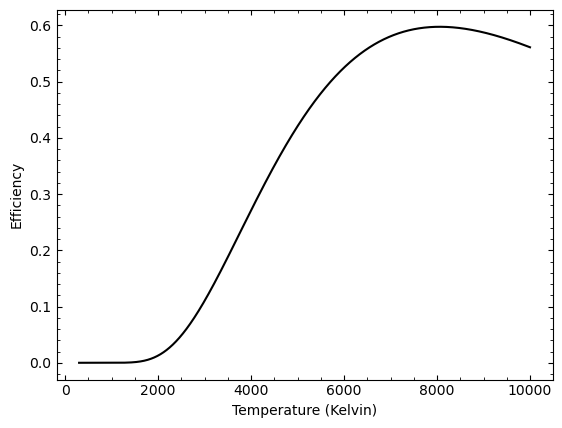

In [7]:
# Some constants to get us going.
# We will use the temperature measured in Kelvin.
Planckh = 6.62606957e-34  # J s, Planck's constant
speedc = 2.99792458e+08  # m/s, speed of light
kB = 1.3806488e-23  # J/K, Boltzmann's constant
lam1 = 300e-9  # m
lam2 = 750e-9  # m
# Conversion factors need for the efficiency.
x1T = Planckh * speedc / (lam1 * kB)  # x1*T, in K
x2T = Planckh * speedc / (lam2 * kB)  # x2*T, in K

def Intensity(x):
    """Blackbody intensity in dimensionless form."""
    return x**3 / (np.exp(x) - 1)

def efficiency(T):
    """Efficiency of a blackbody.
    This is defined as the intensity emitted in visible wavelengths normalized
    by the total intensity of a blackbody with temperature, T, specified in Kelvin.
    """
    return 15 / np.pi**4 * integ.quad(Intensity, x2T / T, x1T / T)[0]

TKelvin = np.linspace(300, 10000, 5000)  # Kelvin
eta = np.zeros_like(TKelvin)
for j in range(len(TKelvin)):
    eta[j] = efficiency(TKelvin[j])

# A more pythonic way of doing this is as follows
#for j, T in enumerate(TKelvin):
#    eta[j] = efficiency(T)
    
# A quick plot to see what it looks like
plt.plot(TKelvin, eta, 'k-')
plt.xlabel('Temperature (Kelvin)')
plt.ylabel('Efficiency');

We can now start to analyze this efficiency. Before doing that, let us consider using `quad_vec` for this problem.

### `quad_vec`

As shown in the documentation, this works on a vectorized function, though it requires the same limits of integration for all integrals we evaluate. Unfortunately, we want to evaluate the integral at multiple temperatures and our simplification above moved the temperature into the limits of integration. To fix this let us go back to the original integral. We had defined the efficiency as the ratio of intensities,
$$ \eta \equiv \frac{\int_{\lambda_1}^{\lambda_2} I(\lambda) \mathrm{d}\lambda}{\int_0^\infty I(\lambda) \mathrm{d}\lambda}, $$
where the intensity was given by
$$ I(\lambda) = \frac{2\pi A h c^2}{\lambda^5 (\mathrm{e}^{h c/\lambda k_B T} - 1)}.$$

To simplify this in a similar way as above, let
$$ y \equiv \frac{h c}{\lambda k_B}. $$
With this we can show that
$$ \eta(T) = \frac{15}{\pi^4 T^4} \int_{y_2}^{y_1} \frac{y^3}{\mathrm{e}^{y/T} - 1} \mathrm{d}y. $$
Notice that $y_1$ is what we called `x1T` and $y_2$ is what we called `x2T` in the code above.

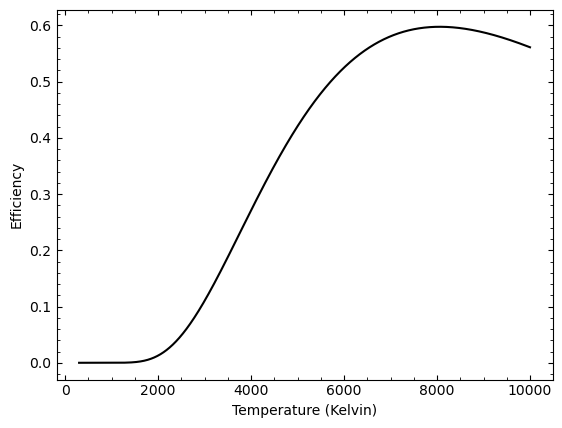

In [8]:
def Intensity_vec(y, T):
    """Blackbody intensity in dimensionless form.
    T is an array of temperatures in Kelvin.
    """
    return y**3 / (np.exp(y / T) - 1)

def efficiency_vec(T):
    """Efficiency of a blackbody.
    This is defined as the intensity emitted in visible wavelengths normalized
    by the total intensity of a blackbody with temperature, T, specified in Kelvin.
    Here T is an array of temperatures.
    workers is an optional argument passed to quad_vec. It determines the number of processes
    to run in parallel for the computation.
    """
    return 15 / (np.pi * T)**4 * integ.quad_vec(Intensity_vec, x2T, x1T, args=(T,))[0]

eta_vec = efficiency_vec(TKelvin)

# A quick plot to see what it looks like
plt.plot(TKelvin, eta_vec, 'k-')
plt.xlabel('Temperature (Kelvin)')
plt.ylabel('Efficiency');

The plots look very similar, lets compare the values. Since we do not know which one is the correct value we will calculate the error as
$$ \epsilon \equiv 2 \left| \frac{\eta_1 - \eta_2}{\eta_1 + \eta_2} \right| . $$

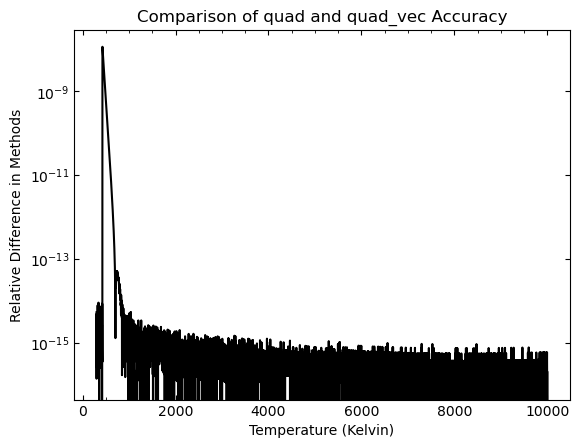

In [9]:
epsilon = 2 * np.abs((eta - eta_vec) / (eta + eta_vec))
plt.semilogy(TKelvin, epsilon, 'k-')
plt.xlabel('Temperature (Kelvin)')
plt.ylabel('Relative Difference in Methods')
plt.title('Comparison of quad and quad_vec Accuracy');

We can also compare how long it takes to perform each computation. We will use the cell magic `%%timeit` for this purpose. (We will encounter this cell magic again in the future.)

Here is the loop.

In [10]:
%%timeit
eta = np.zeros_like(TKelvin)
for j in range(len(TKelvin)):
    eta[j] = efficiency(TKelvin[j])

94.5 ms ± 3.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Here is the vectorized version.

In [11]:
%%timeit
eta_vec = efficiency_vec(TKelvin)

3.91 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We see that `quad_vec` is noticeably more efficient!

### Back to Optimal Temperature

From the quick plots of the efficiency we see it always remains below 60 percent and is a maximum at a rather high temperature. We can find this maximum in a number of ways. One approach is to find where the derivative is zero. We can do this using a spline and a root finder.

(As we saw above, it does not matter whether we use the result from `quad` or `quad_vec` for this analysis.)

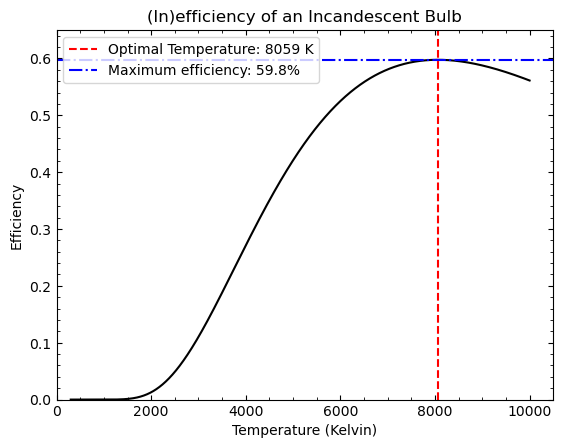

In [12]:
eta_spline = interp.InterpolatedUnivariateSpline(TKelvin, eta)
# Calculate its derivative as a function
eta_spline_deriv = eta_spline.derivative()
Toptimal = opt.brentq(eta_spline_deriv, 4000, 9000)
etamax = efficiency(Toptimal)
# Make a nice plot of the results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(TKelvin, eta, 'k-')
ax.axvline(Toptimal, color='r', ls='--',
            label=f'Optimal Temperature: {Toptimal:.0f} K')
ax.axhline(etamax, color='b', ls='-.',
            label=f'Maximum efficiency: {100*etamax:.1f}%')
ax.legend(loc='best')
ax.set_xlabel('Temperature (Kelvin)')
ax.set_ylabel('Efficiency')
ax.set_title('(In)efficiency of an Incandescent Bulb')
ax.set_xlim(left=0)
ax.set_ylim(0, 0.65);

The optimal temperature is quite high and the value is not too surprising. The Sun is the dominant source of light on the Earth and it can also be approximated as a black body. The surface temperature of the Sun is approximately 5800 K, close to the optimal temperature we find. The exact connection between the two and the role evolution plays in this is more subtle and must be addressed with some care. Further, we could easily include a "response function" for how the eye responds as a function of wavelength in our analysis. See <a href="http://www.phys.ufl.edu/~hagen/phz4710/readings/AJPSofferLynch.pdf">Soffer and Lynch (1999)</a> for more details on these and related issues. This would be a more accurate assessment. Even without that we get the main point: the optimal temperature for operating an incandescent bulb is quite high and the peak efficiency is not all that high.

Overall we see that an incandescent bulb is incredibly inefficient, do we really want to run such a bulb at approximately 8000 K! Even if we did we would only be running at about 60 percent efficiency. Of course this analysis should not be taken too literally. Many things can be/were done to improve the efficiency, an incandescent bulb is not a perfect blackbody, *etc*. Even so, it shows how big a problem must be overcome to make them even marginally efficient. Alternate technologies have thus supplanted the venerable incandescent bulb.